In [1]:
# For extracting the eigenvalue from the ground state estimate, we will use 
# Quantum Phase Estimation, sampled over a data set with different time steps.

In [1]:
import sys

sys.path.append("../../src/groundstate_prep")
from ground_state_prep import prepare_ground_state
from utils_gsp import approx_polynomial, get_phis, U

sys.path.append("../../src/groundstate_prep")
from ground_state_prep_qiskit import qetu_rqc_oneLayer

sys.path.append("../../src/lindbladian")
from lindbladian import ideal_lindbladian, circuit_implementation_lindbladian
from utils_lind import crandn

sys.path.append("../../src/rqcopt")
from optimize import ising1d_dynamics_opt

sys.path.append("../../src/qpe")
from qpe import estimate_phases, qc_estimate_phases

/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [2]:
# Hamiltonian.

import numpy as np
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt

# Parameters for the Ising Hamiltonian
# L has to be even! Due to K only being able to control even Ls!
L, J, h, g = (6, 1, 0, 1)


# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix().toarray()

eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]
print("Ground State Energy", eigenvalues_sort[0].real)

Ground State Energy -7.72740661031253


In [3]:
# Linear transformation of the hamiltonian to fit the eigenvalues in the [-1, 1] interval.

dist = 0.001

# Have to be guessed, depending on the used Hamiltonian
# If we have a good initial overlap, we can decrease this 
# max_spectrum_length and get a larger spectral gap after transformation.
max_spectrum_length = 16
ground_energy_lower_bound = -12
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * ground_energy_lower_bound

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])

print("a_max", a_values[0])
print("a_premax", a_values[1])
print("c1: ", c1)
print("c2: ", c2)
print("t: ", 0.5*c1)

a_max (0.913213738245949-0j)
a_premax (0.902383564242937-0j)
c1:  0.19622454084936208
c2:  2.3556944901923447
t:  0.09811227042468104


Absolute Error for the Eigenvalue:  0.5830838054621958


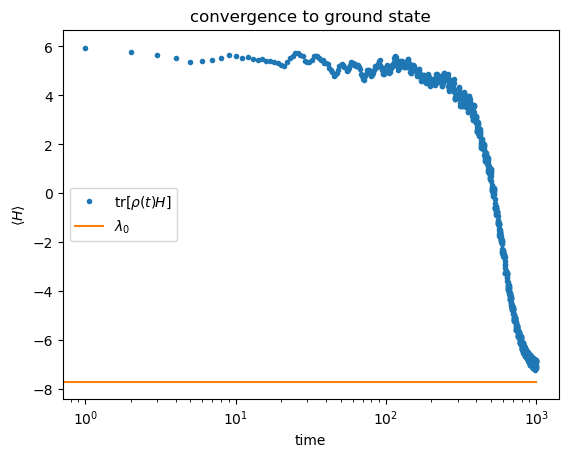


Layer 0
Prob 0: 0.0896073554494281
Prob 1: 0.9103926445505929

Layer 1
Prob 0: 0.11087811782652433
Prob 1: 0.8891218821734971

Layer 2
Prob 0: 0.11449658835974112
Prob 1: 0.8855034116402781

Layer 3
Prob 0: 0.11545161975959484
Prob 1: 0.8845483802404237

Layer 4
Prob 0: 0.11571508516052899
Prob 1: 0.8842849148394895

F(a_max) = (0.11583628418758912+0j)

 ---------- 
 SUCCESS! 

Fidelity of the initial state to the ground state: 0.7291029018103746
Fidelity of the prepared state to the ground state: 0.999667944886196


In [4]:
# Here we use Lindbladian + QETU to prepare the ground state.

mu, d, c, phis_max_iter, = (0.92, 30, 0.95, 10)

tau, nsteps = (1,1000)
end_state_lind, en_list, err = circuit_implementation_lindbladian(hamil, L, tau=tau, nsteps=nsteps)

print("Absolute Error for the Eigenvalue: ", err)
plt.semilogx(tau * np.arange(nsteps + 1), en_list, ".", label=r"$\mathrm{tr}[\rho(t) H]$")
plt.semilogx(tau * np.arange(nsteps + 1), (eigenvalues_sort[0]*np.ones(nsteps + 1)).real, label=r"$\lambda_0$")
plt.legend()
plt.xlabel("time")
plt.ylabel(r"$\langle H \rangle$")
plt.title("convergence to ground state")
plt.show()


ket_0 = np.array([1,0])

end_state_qetu, E = prepare_ground_state(
                        np.kron(ket_0, end_state_lind), mu, d, c, phis_max_iter,
                        np.kron(np.array([1, 0]), ground_state), L, J, g, eigenvalues_sort[0],
                        hamil=hamil, max_reps=5, tau=c1, shift=c2, a_max=a_values[0]
)

In [5]:
# Demonstrate dataset creation for QCELS Fitting with Blanes-Moan Splitting.

import rqcopt as oc
coeffs = oc.SplittingMethod.blanes_moan().coeffs
phase_estimates, phase_exacts = estimate_phases(L, J, g, end_state_qetu, eigenvalues_sort, 
                                                tau=0.01, N=100, shots=1e5, 
                                                depolarizing_error=0, rqc=False, 
                                                coeffs=coeffs, )

/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


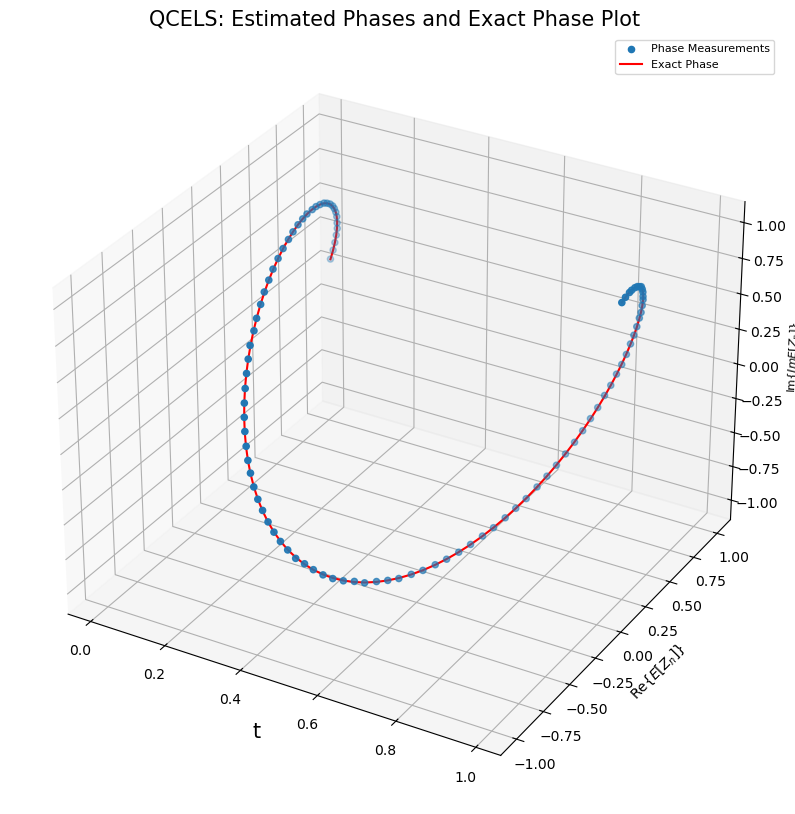

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

phase_estimates = np.array(phase_estimates)
phase_exacts = np.array(phase_exacts)
ax.scatter(phase_estimates[:, 0], phase_estimates[:, 1].real, phase_estimates[:, 1].imag, label="Phase Measurements")
ax.plot(phase_exacts[:,0], phase_exacts[:,1].real, phase_exacts[:,1].imag, label="Exact Phase", color="red")
plt.title("QCELS: Estimated Phases and Exact Phase Plot", size=15
         )
plt.xlabel("t", size=15)
plt.ylabel("Re{" + r"$E[Z_n]$" + "}", size=10)
ax.set_zlabel("Im{" + r"$Im E[Z_n]$" + "}", size=8)
ax.legend(prop={'size': 8})
plt.savefig("../../theory/pdf/TFIM_6_QPE_3d.pdf")

In [8]:
# Fitting of the gathered dataset to an exponential function.

def f(theta, phase_estimates):
    total_sum = 0
    for i, t in enumerate(phase_estimates[:, 0]):
        Zn = phase_estimates[:, 1][i]
        total_sum += Zn * np.exp(1j*t*theta)
    return np.linalg.norm(total_sum)**2

/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/ticker.py:799: ComplexWarning: Casting complex values to real discards the imaginary part
  loc_range_oom = int(math.floor(math.log10(loc_range)))
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/ticker.py:525: ComplexWarning: Casting complex values to real discards the imaginary part
  else fmt % arg)
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/text.py:894: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/text.py:753: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(self._x))
/Users/erenaykaracan/anaconda3/envs/qc/lib/python3.10/site-packages/matplotlib/ticker.py:799: ComplexWarning: Casting complex values to real discards the imaginary pa

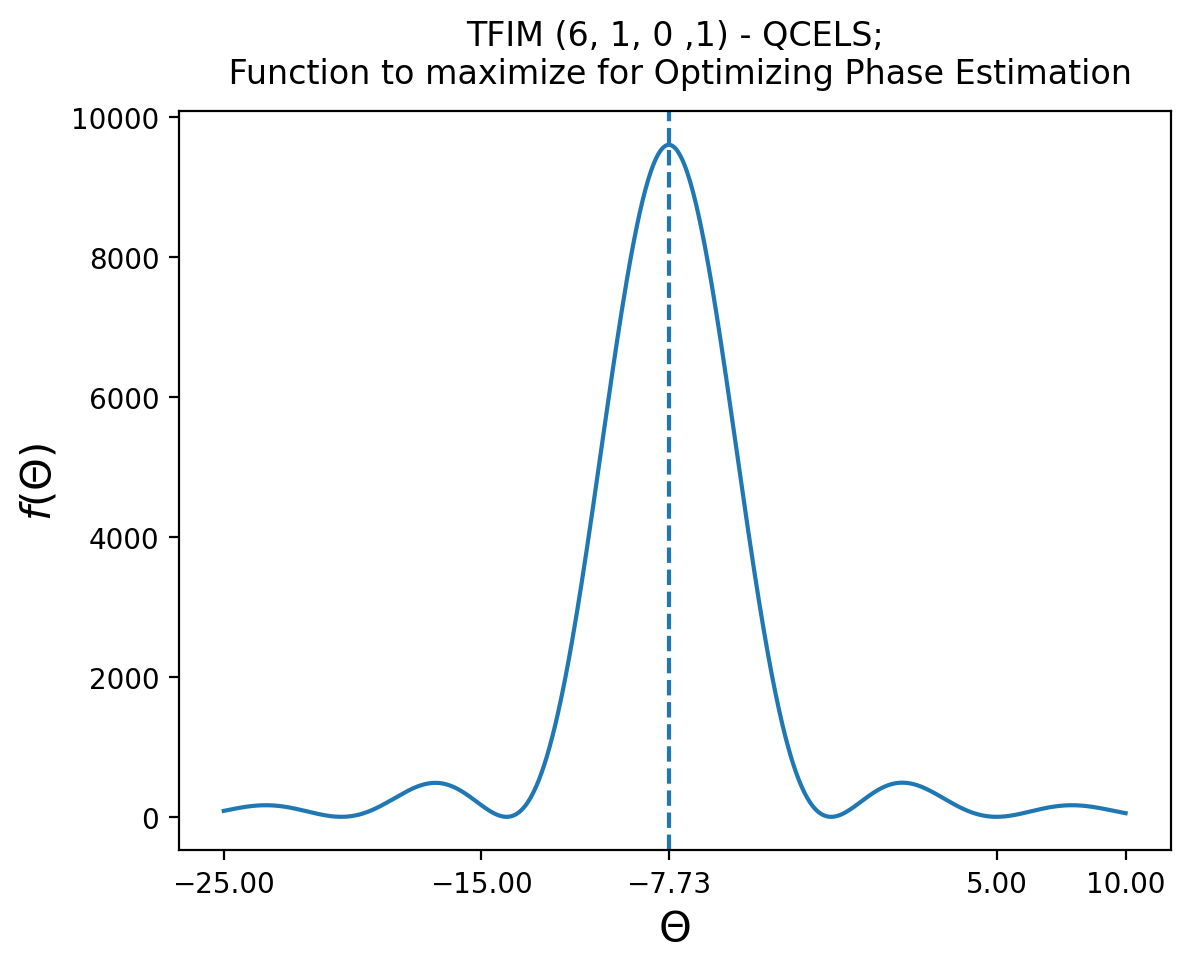

In [9]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
plt.figsize=(10, 10)
theta_values = np.linspace(-25, 10, 1000)
f_values = [f(theta, phase_estimates) for theta in theta_values]
plt.title("TFIM (6, 1, 0 ,1) - QCELS;\n Function to maximize for Optimizing Phase Estimation", size=12, pad=10)
plt.axvline(x=eigenvalues_sort[0], ymin=0, ymax=1, ls="--", label=r"$\lambda_0$")
plt.xlabel(r"$\Theta$", size=15)
plt.ylabel(r"$f(\Theta)$", size=15)
plt.plot(theta_values, f_values)
plt.xticks([-25, 5, -15, 10] + [eigenvalues_sort[0]])
plt.savefig("../../theory/pdf/TFIM_6_QPE_f.pdf")
plt.show()

In [10]:
import scipy

theta0 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates), -7)
print("Absolute Error: ", np.linalg.norm(theta0 - eigenvalues_sort[0]))

Optimization terminated successfully.
         Current function value: -9602.811710
         Iterations: 14
         Function evaluations: 28
Absolute Error:  0.0021990907812785565


In [ ]:
# Demonstrate dataset creation for QCELS Fitting with RQCOpt.

phase_estimates, phase_exacts = estimate_phases(L, J, g, end_state_qetu, eigenvalues_sort, 
                                                tau=0.01, N=100, shots=1e5, 
                                                depolarizing_error=0, rqc=True)

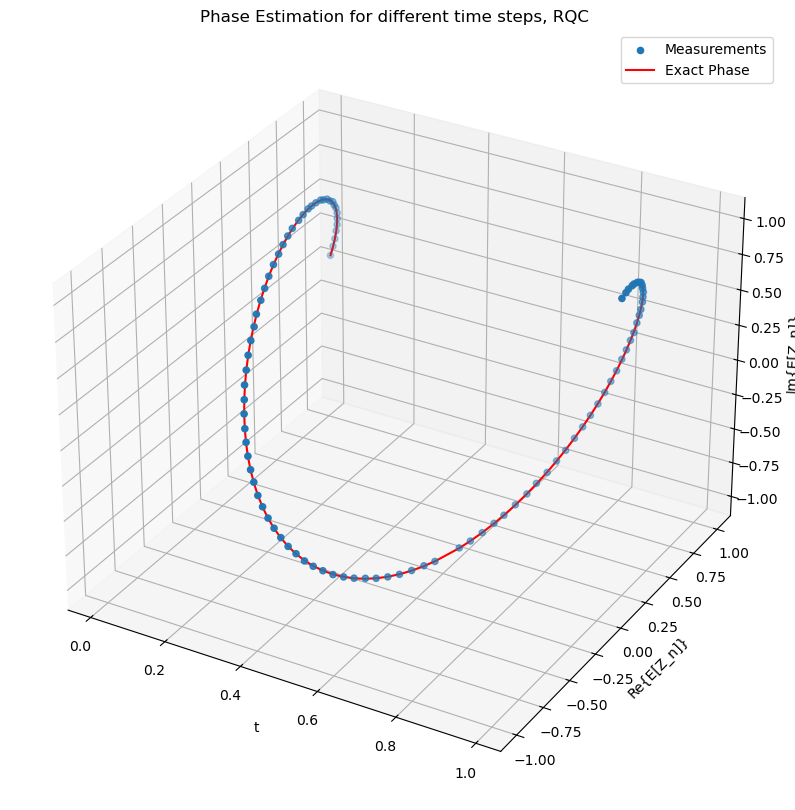

In [33]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

phase_estimates = np.array(phase_estimates)
phase_exacts = np.array(phase_exacts)
ax.scatter(phase_estimates[:, 0], phase_estimates[:, 1].real, phase_estimates[:, 1].imag, label="Measurements")
ax.plot(phase_exacts[:,0], phase_exacts[:,1].real, phase_exacts[:,1].imag, label="Exact Phase", color="red")
plt.title("Phase Estimation for different time steps, RQC")
plt.xlabel("t")
plt.ylabel("Re{E[Z_n]}")
ax.set_zlabel("Im{E[Z_n]}")
ax.legend()

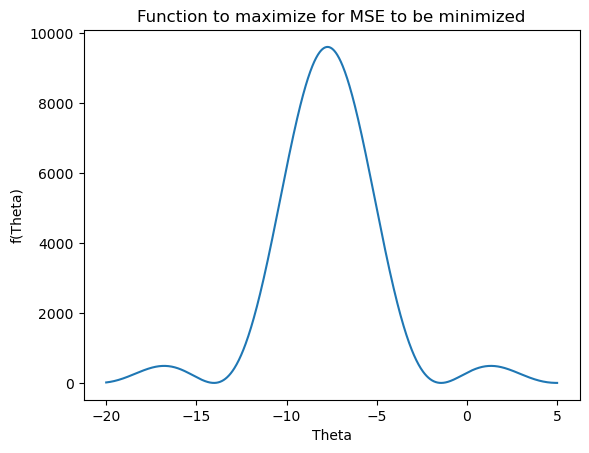

Optimization terminated successfully.
         Current function value: -9603.286570
         Iterations: 14
         Function evaluations: 28
Absolute Error:  0.00019348734372215404


In [34]:
import scipy

def f(theta, phase_estimates):
    total_sum = 0
    for i, t in enumerate(phase_estimates[:, 0]):
        Zn = phase_estimates[:, 1][i]
        total_sum += Zn * np.exp(1j*t*theta)
    return np.linalg.norm(total_sum)**2


theta_values = np.linspace(-20, 5, 1000)
f_values = [f(theta, phase_estimates) for theta in theta_values]
plt.title("Function to maximize for MSE to be minimized")
plt.xlabel("Theta")
plt.ylabel("f(Theta)")
plt.plot(theta_values, f_values)
plt.show()

theta0 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates), -7)
print("Absolute Error: ", np.linalg.norm(theta0 - eigenvalues_sort[0]))

In [5]:
# Demonstrate dataset creation for QCELS Fitting with different 
# time evolution operators and noise 

import rqcopt as oc
coeffs = oc.SplittingMethod.blanes_moan().coeffs

mu = 0.92
qc_qetu_RQC, _, __ = qetu_rqc_oneLayer(
                       L, J, g, c1/2, mu, a_values, c2
)

dt:  0.09811227042468104
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.11583628418758912+0j)
F(a_premax)^2:  (0.03199733348885202+0j)


In [6]:
phase_estimates_RQC_1e4, phase_exacts_RQC_1e4 = qc_estimate_phases(L, J, g, qc_qetu_RQC, eigenvalues_sort, 
                                                tau=0.01, N=25, shots=1e4,
                                                depolarizing_error=1e-4, rqc=True, qetu_repeat=3)


(0.9568000000000001+0.05760000000000004j)
(0.948+0.14680000000000004j)
(0.9392+0.22019999999999995j)
(0.915+0.28200000000000003j)
(0.8857999999999999+0.36000000000000004j)
(0.8573999999999999+0.41640000000000005j)
(0.8171999999999999+0.4986j)
(0.778+0.5558000000000001j)
(0.7452000000000001+0.6035999999999999j)
(0.6906000000000001+0.6606000000000001j)
(0.633+0.7092j)
(0.5811999999999999+0.7669999999999999j)
(0.5296000000000001+0.7914000000000001j)
(0.46680000000000005+0.8348j)
(0.39759999999999995+0.8724000000000001j)
(0.32160000000000005+0.8908j)
(0.25120000000000003+0.9219999999999999j)
(0.1894+0.9374j)
(0.13220000000000004+0.938j)
(0.028200000000000003+0.9454j)
(-0.04400000000000004+0.9423999999999999j)
(-0.12040000000000001+0.9339999999999999j)
(-0.15159999999999996+0.9219999999999999j)
(-0.24619999999999997+0.907j)


In [9]:
import scipy

phase_estimates_RQC_1e4 = np.array(phase_estimates_RQC_1e4)
theta0_RQC_1e4 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates_RQC_1e4), -7)
print(f"RQC, Depolar. Noise: 1e-4 ,Absolute Error: ", np.linalg.norm(theta0_RQC_1e4 - eigenvalues_sort[0]))

Optimization terminated successfully.
         Current function value: -522.945674
         Iterations: 14
         Function evaluations: 28
RQC, Depolar. Noise: 1e-4 ,Absolute Error:  0.07372008687502873


In [64]:
phase_estimates_bm_1e4, phase_exacts_bm_1e4 = qc_estimate_phases(L, J, g, qc_qetu_RQC, eigenvalues_sort, 
                                                tau=0.01, N=125, shots=1e3,
                                                depolarizing_error=1e-4, rqc=False, coeffs=coeffs)


(0.8859999999999999+0.08000000000000002j)
(0.9079999999999999+0.15399999999999997j)
(0.8680000000000001+0.184j)
(0.8580000000000001+0.246j)
(0.8360000000000001+0.35400000000000004j)
(0.8200000000000001+0.342j)
(0.776+0.474j)
(0.76+0.5640000000000001j)
(0.69+0.5780000000000001j)
(0.6319999999999999+0.6399999999999999j)
(0.6160000000000001+0.6799999999999999j)
(0.5780000000000001+0.6839999999999999j)
(0.494+0.756j)
(0.486+0.786j)
(0.318+0.794j)
(0.322+0.8480000000000001j)
(0.22399999999999998+0.8620000000000001j)
(0.14399999999999996+0.8620000000000001j)
(0.04200000000000004+0.8460000000000001j)
(0.03600000000000003+0.8959999999999999j)
(0.006000000000000005+0.8919999999999999j)
(-0.12400000000000005+0.8919999999999999j)
(-0.14999999999999997+0.8740000000000001j)
(-0.21199999999999997+0.8680000000000001j)
(-0.328+0.8320000000000001j)
(-0.37400000000000005+0.802j)
(-0.44399999999999995+0.768j)
(-0.514+0.76j)
(-0.5640000000000001+0.6799999999999999j)
(-0.5820000000000001+0.6659999999999999

In [73]:
import scipy

phase_estimates_bm_1e4 = np.array(phase_estimates_bm_1e4)
theta0_bm_1e4 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates_bm_1e4), -7)
print(f"Blanes-Moan, Depolar. Noise: 1e-4 ,Absolute Error: ", np.linalg.norm(theta0_bm_1e4 - eigenvalues_sort[0]))

Optimization terminated successfully.
         Current function value: -12013.556271
         Iterations: 14
         Function evaluations: 28
Blanes-Moan, Depolar. Noise: 1e-4 ,Absolute Error:  0.009336553749970555


In [63]:
phase_estimates_bm_1e3, phase_exacts_bm_1e3 = qc_estimate_phases(L, J, g, qc_qetu_RQC, eigenvalues_sort, 
                                                tau=0.01, N=125, shots=1e3,
                                                depolarizing_error=1e-3, rqc=False, coeffs=coeffs)



(0.338+0.03600000000000003j)
(0.34+0.08000000000000002j)
(0.36000000000000004+0.06000000000000005j)
(0.39999999999999997+0.12799999999999995j)
(0.31200000000000006+0.09000000000000002j)
(0.33+0.11200000000000004j)
(0.30000000000000004+0.11400000000000005j)
(0.34600000000000003+0.22199999999999998j)
(0.33+0.20399999999999996j)
(0.28600000000000003+0.23199999999999998j)
(0.29200000000000004+0.23199999999999998j)
(0.24+0.274j)
(0.19999999999999996+0.24j)
(0.20599999999999996+0.31200000000000006j)
(0.13399999999999995+0.27j)
(0.19399999999999995+0.262j)
(0.14799999999999996+0.29400000000000004j)
(0.10200000000000004+0.31000000000000005j)
(0.02200000000000002+0.338j)
(0.07400000000000001+0.30000000000000004j)
(0.008000000000000007+0.334j)
(0.006000000000000005+0.19199999999999995j)
(-0.01200000000000001+0.246j)
(-0.05800000000000005+0.29000000000000004j)
(-0.10600000000000004+0.28400000000000003j)
(-0.10600000000000004+0.29200000000000004j)
(-0.10600000000000004+0.28600000000000003j)
(-0.14

In [72]:
import scipy

phase_estimates_bm_1e3 = np.array(phase_estimates_bm_1e3)
theta0_bm_1e3 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates_bm_1e3), -7)
print(f"Blanes-Moan, Depolar. Noise: 1e-3 ,Absolute Error: ", np.linalg.norm(theta0_bm_1e3 - eigenvalues_sort[0]))

Optimization terminated successfully.
         Current function value: -1283.705683
         Iterations: 14
         Function evaluations: 28
Blanes-Moan, Depolar. Noise: 1e-3 ,Absolute Error:  0.13528870218747002


In [ ]:
phase_estimates_bm_1e2, phase_exacts_bm_1e2 = qc_estimate_phases(L, J, g, qc_qetu_RQC, eigenvalues_sort, 
                                                tau=0.01, N=25, shots=1e3,
                                                depolarizing_error=1e-2, rqc=False, coeffs=coeffs)

In [16]:
phase_estimates_bm_1e2 = np.array(phase_estimates_bm_1e2)
theta0_bm_1e2 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates_bm_1e2), -7)
print(f"Blanes-Moan, Depolar. Noise: 1e-2 ,Absolute Error: ", np.linalg.norm(theta0_bm_1e2 - eigenvalues_sort[0]))

Optimization terminated successfully.
         Current function value: -0.008295
         Iterations: 22
         Function evaluations: 44
Blanes-Moan, Depolar. Noise: 1e-2 ,Absolute Error:  12.955234991249968


In [65]:
phase_estimates_bm_1e5, phase_exacts_bm_1e5 = qc_estimate_phases(L, J, g, qc_qetu_RQC, eigenvalues_sort, 
                                                tau=0.01, N=125, shots=1e3,
                                                depolarizing_error=1e-5, rqc=False, coeffs=coeffs)

(0.99+0.09400000000000003j)
(0.98+0.12599999999999995j)
(0.968+0.274j)
(0.94+0.318j)
(0.8879999999999999+0.36400000000000005j)
(0.8759999999999999+0.426j)
(0.8700000000000001+0.512j)
(0.8340000000000001+0.5960000000000001j)
(0.748+0.6359999999999999j)
(0.6779999999999999+0.698j)
(0.6799999999999999+0.748j)
(0.5960000000000001+0.8280000000000001j)
(0.5+0.8460000000000001j)
(0.46799999999999997+0.8999999999999999j)
(0.40199999999999997+0.9339999999999999j)
(0.31000000000000005+0.9219999999999999j)
(0.266+0.952j)
(0.15199999999999997+0.964j)
(0.08800000000000002+0.978j)
(-0.066+0.988j)
(-0.11400000000000005+0.99j)
(-0.174+0.958j)
(-0.238+0.958j)
(-0.37799999999999995+0.9119999999999999j)
(-0.43999999999999995+0.9039999999999999j)
(-0.472+0.8759999999999999j)
(-0.5700000000000001+0.8360000000000001j)
(-0.6439999999999999+0.78j)
(-0.6479999999999999+0.734j)
(-0.714+0.688j)
(-0.768+0.6200000000000001j)
(-0.786+0.554j)
(-0.8500000000000001+0.496j)
(-0.8899999999999999+0.484j)
(-0.938+0.366000

In [70]:
phase_estimates_bm_1e5 = np.array(phase_estimates_bm_1e5)
theta0_bm_1e5 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates_bm_1e5), -7)
print(f"Blanes-Moan, Depolar. Noise: 1e-5 ,Absolute Error: ", np.linalg.norm(theta0_bm_1e5 - eigenvalues_sort[0]))

Optimization terminated successfully.
         Current function value: -14809.982238
         Iterations: 14
         Function evaluations: 28
Blanes-Moan, Depolar. Noise: 1e-5 ,Absolute Error:  0.0016009462500283789


In [91]:
# Demonstrate dataset creation for QCELS Fitting with Blanes-Moan Splitting.

import rqcopt as oc
coeffs = oc.SplittingMethod.blanes_moan().coeffs
phase_estimates, phase_exacts = estimate_phases(L, J, g, end_state_qetu, eigenvalues_sort, 
                                                tau=0.01, N=125, shots=1e4, 
                                                depolarizing_error=0, rqc=False, 
                                                coeffs=coeffs, )

In [92]:

phase_estimates = np.array(phase_estimates)
theta0 = scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates), -7)
print(f"Blanes-Moan, Depolar. Noise: 1e-5 ,Absolute Error: ", np.linalg.norm(theta0 - eigenvalues_sort[0]))

Optimization terminated successfully.
         Current function value: -15130.010920
         Iterations: 14
         Function evaluations: 28
Blanes-Moan, Depolar. Noise: 1e-5 ,Absolute Error:  0.002455438437529267


In [74]:
#errs_e2 = [np.linalg.norm(scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates_bm_1e2[:n]), -7) - eigenvalues_sort[0]) for n in N]
errs_e3 = [np.linalg.norm(scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates_bm_1e3[:n]), -7) - eigenvalues_sort[0]) for n in N]
errs_e4 = [np.linalg.norm(scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates_bm_1e4[:n]), -7) - eigenvalues_sort[0]) for n in N]
errs_e5 = [np.linalg.norm(scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates_bm_1e5[:n]), -7) - eigenvalues_sort[0]) for n in N]
errs = [np.linalg.norm(scipy.optimize.fmin(lambda theta: -f(theta, phase_estimates[:n]), -7) - eigenvalues_sort[0]) for n in N]

Optimization terminated successfully.
         Current function value: -238.851515
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -248.506672
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -257.605956
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -266.680609
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -275.351756
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -284.638565
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -292.959510
         Iterations: 14
         Function evaluations: 28
Optimization 

Optimization terminated successfully.
         Current function value: -1216.786541
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -1235.735253
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -1257.615309
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -1283.705683
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -1979.363917
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -2055.340254
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -2135.977031
         Iterations: 14
         Function evaluations: 28
Optimi

Optimization terminated successfully.
         Current function value: -11252.647173
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -11445.058963
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -11631.956630
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -11825.163695
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -12013.556271
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -2461.019876
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -2557.532910
         Iterations: 14
         Function evaluations: 28
O

Optimization terminated successfully.
         Current function value: -14099.562845
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -14333.700905
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -14571.052876
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -14809.982238
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -14809.982238
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -2480.367897
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -2582.697625
         Iterations: 14
         Function evaluations: 28
O

Optimization terminated successfully.
         Current function value: -10525.977682
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -10727.031903
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -10939.836648
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -11150.561900
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -11362.753898
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -11580.736409
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: -11793.986349
         Iterations: 14
         Function evaluations: 28

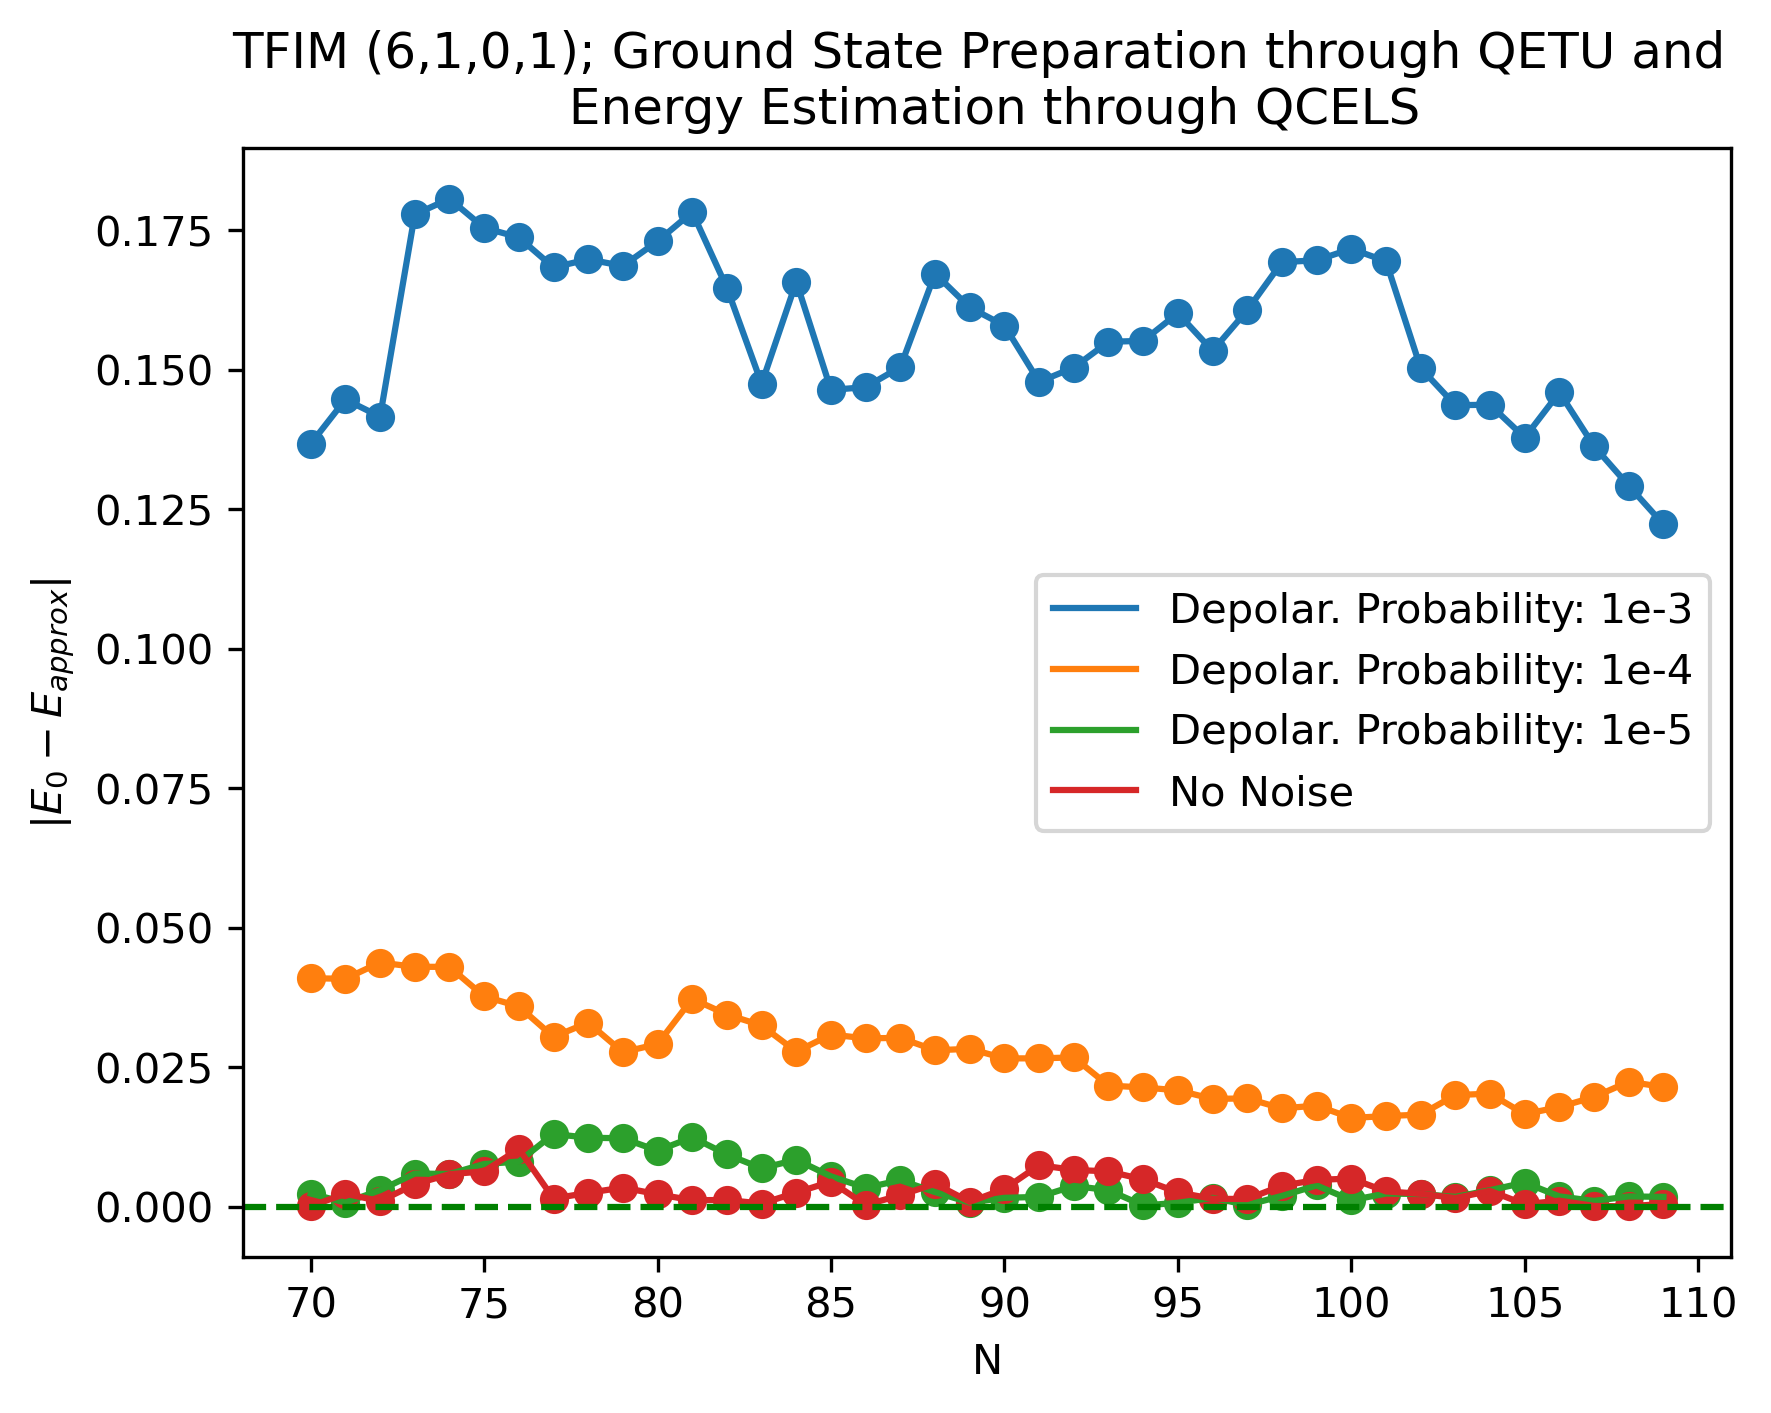

In [97]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

plt.xlabel("N")
plt.ylabel(r"$ |E_{0} - E_{approx}| $")
plt.title("TFIM (6,1,0,1); Ground State Preparation through QETU and \n Energy Estimation through QCELS")
plt.plot(N[20:-15], errs_e3[20:-15], label="Depolar. Probability: 1e-3")
plt.plot(N[20:-15], errs_e4[20:-15], label="Depolar. Probability: 1e-4")
plt.plot(N[20:-15], errs_e5[20:-15], label="Depolar. Probability: 1e-5")
plt.plot(N[20:-15], errs[20:-15], label="No Noise")
plt.axhline(y=0, ls="--", color="green")

plt.scatter(N[20:-15], errs_e3[20:-15])
plt.scatter(N[20:-15], errs_e4[20:-15])
plt.scatter(N[20:-15], errs_e5[20:-15])
plt.scatter(N[20:-15], errs[20:-15])
plt.legend()

plt.savefig("../../theory/pdf/TFIM_6_QCELS_errors.pdf")

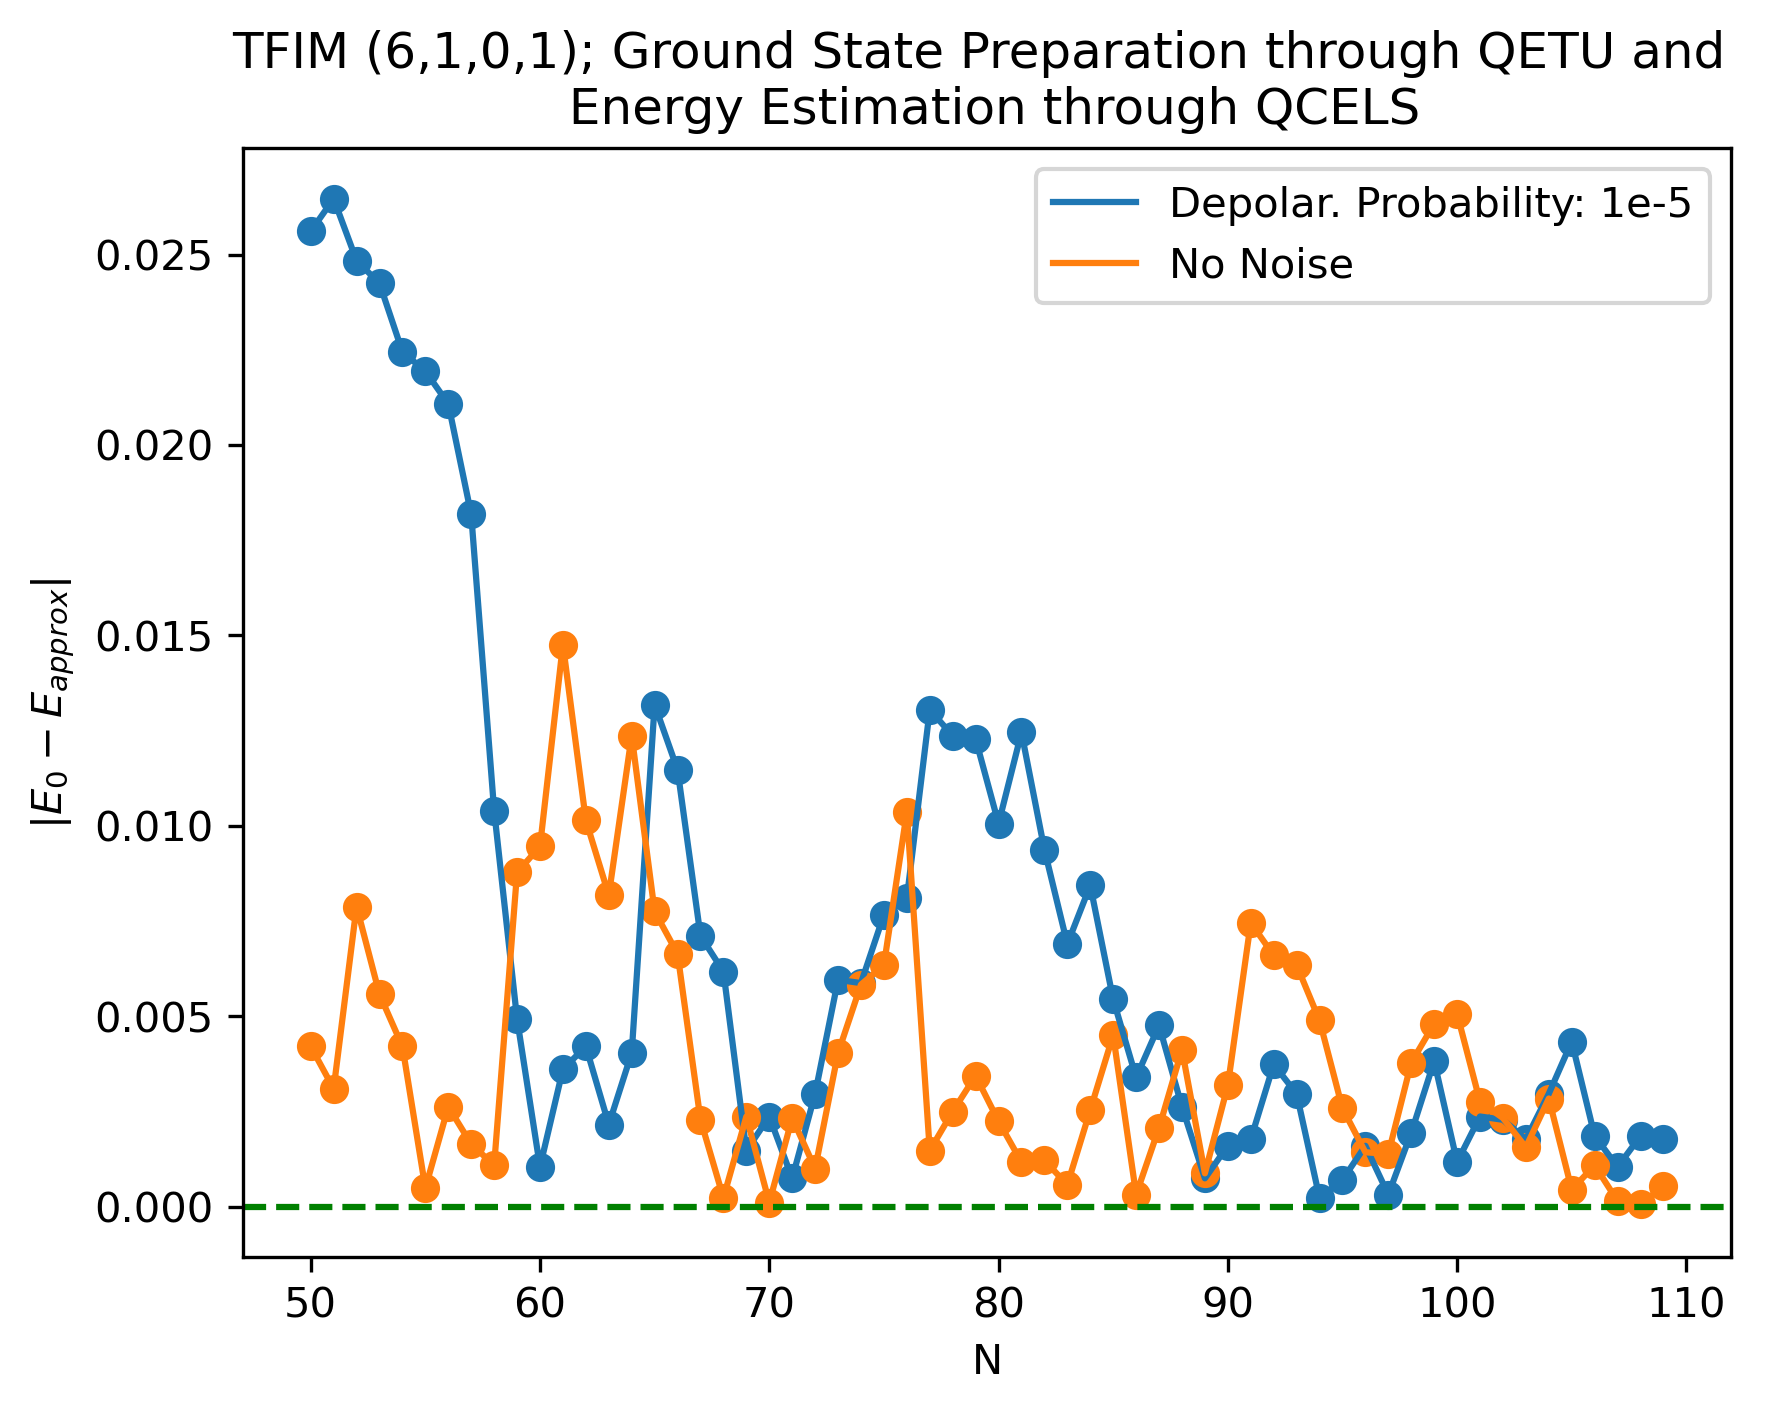

In [103]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

plt.xlabel("N")
plt.ylabel(r"$ |E_{0} - E_{approx}| $")
plt.title("TFIM (6,1,0,1); Ground State Preparation through QETU and \n Energy Estimation through QCELS")
#plt.plot(N[30:], errs_e3[30:], label="Depolar. Probability: 1e-3")
#plt.plot(N[20:-15], errs_e4[20:-15], label="Depolar. Probability: 1e-4")
plt.plot(N[:-15], errs_e5[:-15], label="Depolar. Probability: 1e-5")
plt.plot(N[:-15], errs[:-15], label="No Noise")
plt.axhline(y=0, ls="--", color="green")

#plt.scatter(N[30:], errs_e3[30:])
#plt.scatter(N[20:-15], errs_e4[20:-15])
plt.scatter(N[:-15], errs_e5[:-15])
plt.scatter(N[:-15], errs[:-15])
plt.legend()

plt.savefig("../../theory/pdf/TFIM_6_QCELS_errors_magnified.pdf")

In [102]:
"""TFIM no noise lower bound"""
errs[-17]

6.28603125285565e-05